In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os.path
import pandas as pd
import seaborn as sns
#from MyML.helper.plotting import save_fig

In [54]:
sns.set_style("whitegrid")
fig_width = 8
fig_height = 6

In [55]:
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 600.0

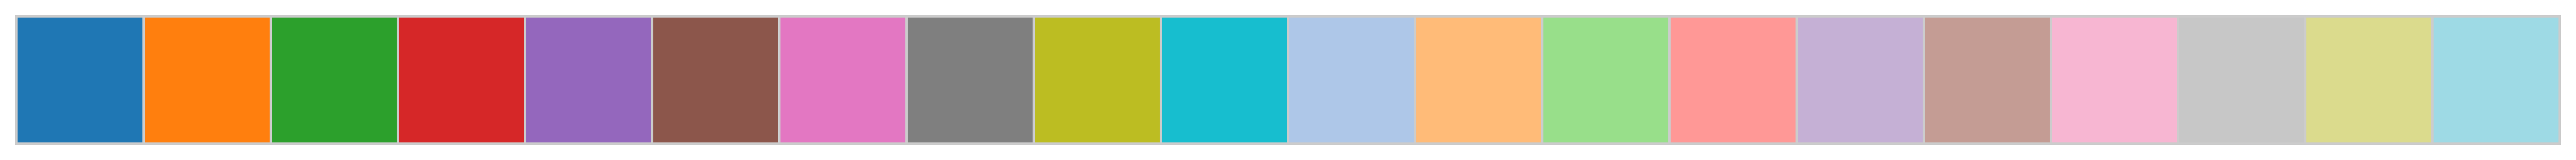

In [56]:
# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
tableau = tableau20[::2]
tableau.extend(tableau20[1::2])
tableau = sns.color_palette(tableau,20)
sns.palplot(tableau)
sns.set_palette(tableau, n_colors=20)

In [57]:
ppt_results = '''/home/chiroptera/QCThesis/results/kmeans/mariana/kmeans_results_500k_16ppt.csv
/home/chiroptera/QCThesis/results/kmeans/mariana/kmeans_results_500k_8ppt.csv
/home/chiroptera/QCThesis/results/kmeans/mariana/kmeans_results_500k_4ppt.csv
/home/chiroptera/QCThesis/results/kmeans/mariana/kmeans_results_500k_2ppt.csv'''
ppt_results = ppt_results.splitlines()

In [58]:
results_path = '/home/chiroptera/QCThesis/results/kmeans/mariana/kmeans_results_1ppt_complete.csv'

In [59]:
base_path = 'C:\\Users\\Isabella\\Downloads\\working_data\\working_data\\results\\kmeans'
ppt_results = [s.replace('/','\\') for s in ppt_results]
ppt_results = [s.replace('\\home\\chiroptera\\QCThesis\\results\\kmeans',base_path) for s in ppt_results]
results_path = results_path.replace('/','\\').replace('\\home\\chiroptera\\QCThesis\\results\\kmeans',base_path)

In [60]:
ppt_res = [pd.read_csv(path) for path in ppt_results]

In [61]:
res = pd.read_csv(results_path)
for col in res.columns:
    print col

Unnamed: 0
Unnamed: 0.1
cardinality
dimensionality
number of clusters
number of iterations
label mode
centroid mode
round
total time
label time
centroid time
cum_data_transfer
n_data_transfer
std_data_transfer
max_data_transfer
min_data_transfer
cum_centroids_transfer
n_centroids_transfer
std_centroids_transfer
max_centroids_transfer
min_centroids_transfer
cum_labels_transfer
n_labels_transfer
std_labels_transfer
max_labels_transfer
min_labels_transfer
cum_dists_transfer
n_dists_transfer
std_dists_transfer
max_dists_transfer
min_dists_transfer
cum_kernel
n_kernel
std_kernel
max_kernel
min_kernel


In [62]:
# time not spend in either computing the labels or the centroids
res['useless time'] = res['total time'] - (res['label time'] + res['centroid time'])

In [63]:
# build new results with all modes in same row

# get columns and ignore index column
new_cols = list(res.columns.values)[1:]
new_cols.remove('total time')
new_cols.remove('useless time') # I'll save stats instead of this
new_cols.remove('label time')
new_cols.remove('centroid time')
new_cols.remove('label mode')
new_cols.remove('centroid mode')
new_cols.extend(['python label time', 'python centroid time',
                 'numpy label time', 'numpy centroid time',
                 'numba label time', 'numba centroid time',
                 'cuda label time',
                 'useless time mean', 'useless time std', 'useless time min', 'useless time max'])
cuda_event_timings_keys = [  'n_data_transfer', 'cum_data_transfer', 'std_data_transfer', 'max_data_transfer', 'min_data_transfer',
                             'n_centroids_transfer', 'cum_centroids_transfer', 'std_centroids_transfer', 'max_centroids_transfer', 'min_centroids_transfer',
                             'n_labels_transfer', 'cum_labels_transfer', 'std_labels_transfer', 'max_labels_transfer', 'min_labels_transfer',
                             'n_dists_transfer', 'cum_dists_transfer', 'std_dists_transfer', 'max_dists_transfer', 'min_dists_transfer',
                             'n_kernel', 'cum_kernel', 'std_kernel', 'max_kernel', 'min_kernel']
#new_cols.extend(cuda_event_timings_keys)
cres = pd.DataFrame(columns=new_cols)

In [64]:
idx = 0
for key, grp in res.groupby(by=['cardinality','dimensionality','number of clusters','number of iterations','round']):
    new_row = {col: 0 for col in cres.columns}
    
    card, dim, nc, niter, r = key
    
    new_row['cardinality'] = card
    new_row['dimensionality'] = dim
    new_row['number of clusters'] = nc
    new_row['number of iterations'] = niter
    new_row['round'] = r
    
    #card, dim, nc, niter, r = key
    
    numba_time_count = 0
    
    if (grp['label mode'] == 'python').any():
        py_label, py_centroid = grp[grp['label mode']=='python'][['label time', 'centroid time']].values[0]
        new_row['python label time'] = py_label
        new_row['python centroid time'] = py_centroid
        
    if (grp['label mode'] == 'numpy').any():
        np_label, np_centroid = grp[grp['label mode']=='numpy'][['label time', 'centroid time']].values[0]
        new_row['numpy label time'] = np_label
        new_row['numpy centroid time'] = np_centroid
        
    if (grp['label mode'] == 'numba').any():
        numba_time_count += 1
        nb_label, nb_centroid = grp[grp['label mode']=='numba'][['label time', 'centroid time']].values[0]
        new_row['numba centroid time'] = 1.0 * (new_row.get('numba centroid time', 0.0) + nb_centroid) / numba_time_count
        new_row['numba label time'] = nb_label
        
    if (grp['label mode'] == 'cuda').any():
        numba_time_count += 1
        cuda_label, nb_centroid2 = grp[grp['label mode']=='cuda'][['label time', 'centroid time']].values[0]
        new_row['numba centroid time'] = 1.0 * (new_row.get('numba centroid time', 0.0) + nb_centroid2) / numba_time_count
        new_row['cuda label time'] = cuda_label
        
        for cet_key in cuda_event_timings_keys:
            new_row[cet_key] = grp[grp['label mode'] == 'cuda'][cet_key].values[0]

    useless_time_mean = grp['useless time'].mean()
    useless_time_std = grp['useless time'].std()
    useless_time_min = grp['useless time'].min()
    useless_time_max = grp['useless time'].max()
        
    new_row['useless time mean'] = useless_time_mean
    new_row['useless time std'] = useless_time_std
    new_row['useless time min'] = useless_time_min
    new_row['useless time max'] = useless_time_max
    
    cres.loc[idx] = new_row
    idx += 1        

    
# compute data, centroids, labels and dists sizes
cres['data_size'] = cres.cardinality * cres.dimensionality * 4
cres['centroids_size'] = cres['number of clusters'] * cres.dimensionality * 4
cres['labels_dists_size'] = cres.cardinality * 4

#print key
#grp[grp['label mode']=='python']
#python_label_time = grp[grp['label mode']=='python']['label time']

In [65]:
cres['cuda numba total speedup'] = (cres['numba label time'] + cres['numba centroid time']) / (cres['cuda label time'] + cres['numba centroid time'])
cres['cuda numba label speedup'] = cres['numba label time'] / cres['cuda label time']
cres['cuda numba label kernel speedup'] = cres['numba label time'] / cres['cum_kernel']
cres['max label numba speedup'] = 1.0 / (cres['numba centroid time'] / (cres['numba label time'] + cres['numba centroid time']))
cres['max centroid numba speedup'] = 1.0 / (cres['numba label time'] / (cres['numba label time'] + cres['numba centroid time']))

print cres['cuda numba label speedup'].max()

24.1517997273


In [66]:
print 'max label computation speedup: ',cres['cuda numba label kernel speedup'].max()
print 'max label speedup:             ',cres['cuda numba label speedup'].max()
print 'max total speedup:             ',cres['cuda numba total speedup'].max()

max label computation speedup:  35.2707972966
max label speedup:              24.1517997273
max total speedup:              23.6615532987


# average out over rounds

In [67]:
cres_mean = cres.groupby(by=['cardinality','dimensionality','number of clusters','number of iterations']).mean()
cres_mean = cres_mean.reset_index()

In [68]:
cres_mean['data_bandwidth']=((cres_mean['data_size'] * cres_mean['n_data_transfer']) / (cres_mean['cum_data_transfer']))/(1024.0**2)
cres_mean['centroids_bandwidth']=((cres_mean['centroids_size'] * cres_mean['n_centroids_transfer']) / (cres_mean['cum_centroids_transfer']))/(1024.0**2)
cres_mean['labels_bandwidth']=((cres_mean['labels_dists_size'] * cres_mean['n_labels_transfer']) / (cres_mean['cum_labels_transfer']))/(1024.0**2)
cres_mean['dists_bandwidth']=((cres_mean['labels_dists_size'] * cres_mean['n_dists_transfer']) / (cres_mean['cum_dists_transfer']))/(1024.0**2)
cres_mean['throughput'] = cres_mean[['cardinality','dimensionality','number of clusters']].prod(axis=1) * 3 + cres_mean['cardinality'] * (cres_mean['number of clusters'] - 1)
cres_mean['throughput CPU'] = (cres_mean['throughput'] / cres_mean['numba label time']) / (10.0**9)
cres_mean['throughput'] /= cres_mean['cum_kernel']
cres_mean['throughput'] /= 10**9

In [69]:
cres_mean['cum_transfer_times'] = cres_mean[['cum_data_transfer','cum_centroids_transfer','cum_labels_transfer','cum_dists_transfer']].sum(axis=1)
cres_mean['cum_transfer_bytes'] = cres_mean[['n_labels_transfer','labels_dists_size']].sum(axis=1) + cres_mean[['n_dists_transfer','labels_dists_size']].sum(axis=1) + cres_mean[['n_centroids_transfer','centroids_size']].sum(axis=1) + cres_mean[['n_data_transfer','data_size']].sum(axis=1)
cres_mean['total_bandwidth'] = cres_mean['cum_transfer_bytes'] / cres_mean['cum_transfer_times']
cres_mean['total_bandwidth'] /= (1024.0**3)

In [70]:
print cres_mean[['total_bandwidth','throughput','throughput CPU']].describe().to_latex()

\begin{tabular}{lrrr}
\toprule
{} &  total\_bandwidth &  throughput &  throughput CPU \\
\midrule
count &       309.000000 &  309.000000 &      309.000000 \\
mean  &         2.902388 &    3.655521 &        1.048632 \\
std   &         2.278465 &    4.510252 &        0.330869 \\
min   &         0.001433 &    0.003631 &        0.029959 \\
25\%   &         0.567006 &    1.547014 &        0.872651 \\
50\%   &         2.892260 &    1.711037 &        1.179825 \\
75\%   &         5.319831 &    4.168283 &        1.296973 \\
max   &         6.044631 &   21.915104 &        1.447981 \\
\bottomrule
\end{tabular}



In [73]:
%matplotlib qt

In [74]:
plt.ioff()

In [ ]:
# rules in different plots
title = 'Label speed-up'
fixed_clusters = dict()
fig_dict = fixed_clusters

#par3_name : parameter on the x axis
#par2_name : different curves in the same plot
#par1_name : different plots

#par1_name, par2_name = 'number of clusters', 'dimensionality'
par1_name, par2_name, par3_name = 'number of clusters','dimensionality','cardinality'


par_list = res[par1_name].unique()
#fig2.suptitle('Coassoc build time: comparisson between rules for each matrix type', size=16)


for par1, grp in cres_mean.groupby(by=par1_name):
    fig = plt.figure(figsize=(fig_width*1.5, fig_height))
    ax = fig.add_subplot(111)
    fig_dict[par1] = ax
    for par2, grp2 in grp.groupby(by=par2_name):
        idx = grp.cardinality <= 5e5
        trace = '-'
        ax.plot(grp2.loc[idx,par3_name], grp2.loc[idx,'cuda numba label speedup'], trace, label=par2)
    xmin,xmax = ax.get_axes().axis()[:2]
    ax.plot([xmin,xmax], [1,1],'k-.')

for par, ax in fig_dict.iteritems():
    ax.set_xlabel('# patterns',fontsize=16)
    ax.set_ylabel("Speed-up", fontsize=16)
    ax.set_title('{}, # clusters={}'.format(title,par), fontsize=16)
    ax.set_position([0.1,0.1,0.75,0.8])
    ax.legend(title=par2_name, prop={'size':16}, loc = 'center left', bbox_to_anchor = (1.0, 0.5))
    ax.grid(True, which="both")
    ax.set_xscale("log")
    #ax.set_yscale("log")

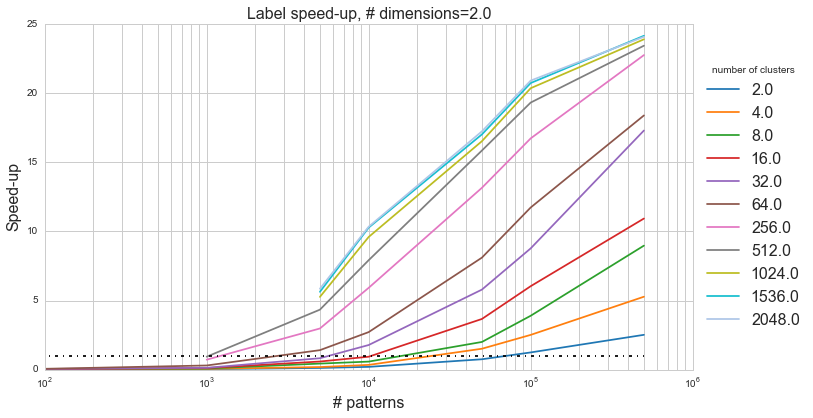

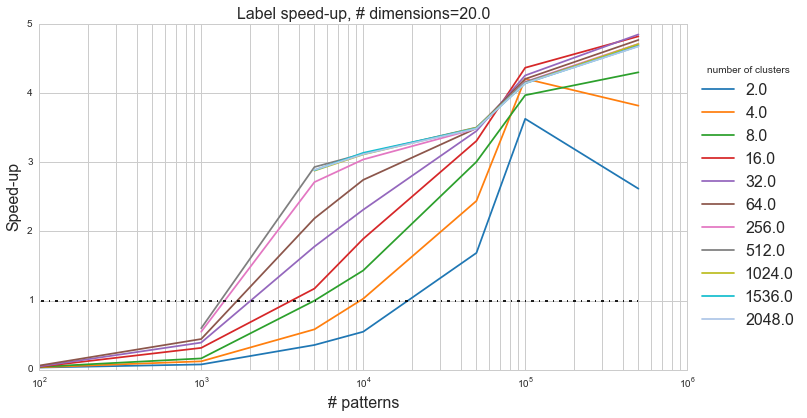

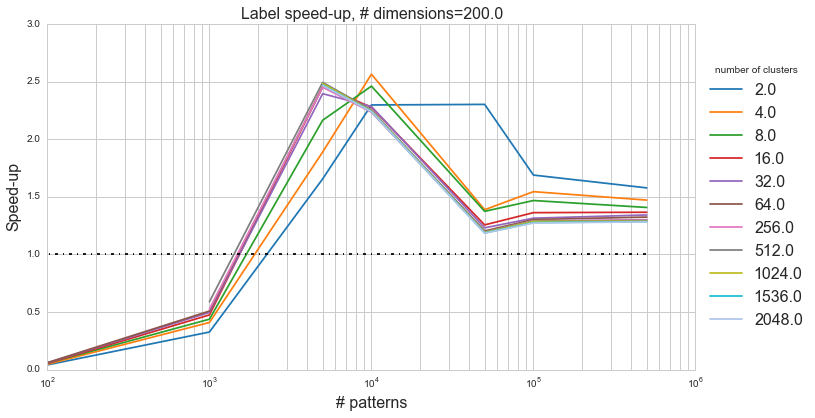

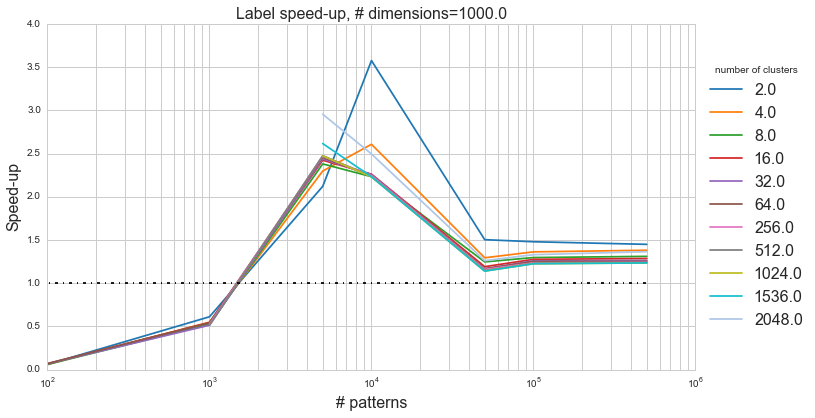

In [75]:
# rules in different plots
title = 'Label speed-up'
fixed_dimensions = dict()
fig_dict = fixed_dimensions

#par3_name : parameter on the x axis
#par2_name : different curves in the same plot
#par1_name : different plots

#par1_name, par2_name = 'number of clusters', 'dimensionality'
par1_name, par2_name, par3_name = 'dimensionality','number of clusters','cardinality'


par_list = res[par1_name].unique()
#fig2.suptitle('Coassoc build time: comparisson between rules for each matrix type', size=16)


for par1, grp in cres_mean.groupby(by=par1_name):
    fig = plt.figure(figsize=(fig_width*1.5, fig_height))
    ax = fig.add_subplot(111)
    fig_dict[par1] = ax
    for par2, grp2 in grp.groupby(by=par2_name):
        idx = grp.cardinality <= 5e5
        trace = '-'
        ax.plot(grp2.loc[idx,par3_name], grp2.loc[idx,'cuda numba label speedup'], trace, label=par2)
    xmin,xmax = ax.get_axes().axis()[:2]
    ax.plot([xmin,xmax], [1,1],'k-.')

for par, ax in fig_dict.iteritems():
    ax.set_xlabel('# patterns',fontsize=16)
    ax.set_ylabel("Speed-up", fontsize=16)
    ax.set_title('{}, # dimensions={}'.format(title,par), fontsize=16)
    ax.set_position([0.1,0.1,0.75,0.8])
    ax.legend(title=par2_name, prop={'size':16}, loc = 'center left', bbox_to_anchor = (1.0, 0.5))
    ax.grid(True, which="both")
    ax.set_xscale("log")
    #ax.set_yscale("log")

In [ ]:
# rules in different plots
title = 'Label speed-up'
fixed_cardinality_nc = dict()
fig_dict = fixed_cardinality_nc

#par3_name : parameter on the x axis
#par2_name : different curves in the same plot
#par1_name : different plots

#par1_name, par2_name = 'number of clusters', 'dimensionality'
par1_name, par2_name, par3_name = 'cardinality','dimensionality','number of clusters'


par_list = res[par1_name].unique()
#fig2.suptitle('Coassoc build time: comparisson between rules for each matrix type', size=16)


for par1, grp in cres_mean.groupby(by=par1_name):
    fig = plt.figure(figsize=(fig_width*1.5, fig_height))
    ax = fig.add_subplot(111)
    fig_dict[par1] = ax
    for par2, grp2 in grp.groupby(by=par2_name):
        idx = grp.cardinality <= 1e10
        trace = '-'
        ax.plot(grp2.loc[idx,par3_name], grp2.loc[idx,'cuda numba label speedup'], trace, label=par2)
    xmin,xmax = ax.get_axes().axis()[:2]
    ax.plot([xmin,xmax], [1,1],'k-.')

for par, ax in fig_dict.iteritems():
    ax.set_xlabel('# clusters',fontsize=16)
    ax.set_ylabel("Speed-up", fontsize=16)
    ax.set_title('{}, # patterns={}'.format(title,par), fontsize=16)
    ax.set_position([0.1,0.1,0.75,0.8])
    ax.legend(title=par2_name, prop={'size':16}, loc = 'center left', bbox_to_anchor = (1.0, 0.5))
    ax.grid(True, which="both")
    ax.set_xscale("log")
    #ax.set_yscale("log")

In [ ]:
# rules in different plots
title = 'Label speed-up'
fixed_cardinality_dimensions = dict()
fig_dict = fixed_cardinality_dimensions

#par3_name : parameter on the x axis
#par2_name : different curves in the same plot
#par1_name : different plots

#par1_name, par2_name = 'number of clusters', 'dimensionality'
par1_name, par2_name, par3_name = 'cardinality','number of clusters','dimensionality'


par_list = res[par1_name].unique()
#fig2.suptitle('Coassoc build time: comparisson between rules for each matrix type', size=16)


for par1, grp in cres_mean.groupby(by=par1_name):
    fig = plt.figure(figsize=(fig_width*1.5, fig_height))
    ax = fig.add_subplot(111)
    fig_dict[par1] = ax
    for par2, grp2 in grp.groupby(by=par2_name):
        idx = grp2.cardinality <= 1e10
        trace = '-'
        ax.plot(grp2.loc[idx,par3_name], grp2.loc[idx,'cuda numba label speedup'], trace, label=par2)
    xmin,xmax = ax.get_axes().axis()[:2]
    ax.plot([xmin,xmax], [1,1],'k-.')

for par, ax in fig_dict.iteritems():
    ax.set_xlabel('# dimensions',fontsize=16)
    ax.set_ylabel("Speed-up", fontsize=16)
    ax.set_title('{}, # patterns={}'.format(title,par), fontsize=16)
    ax.set_position([0.1,0.1,0.75,0.8])
    #ax.legend(loc=(1.1, 0.0), title=par2_name, prop={'size':16})#loc=(1.1, 0.0))
    ax.legend(title=par2_name, prop={'size':16}, loc = 'center left', bbox_to_anchor = (1.0, 0.5))
    ax.grid(True, which="both")
    ax.set_xscale("log")
    #ax.set_yscale("log")

In [ ]:
print cres_mean.query('cardinality > 1000 & cardinality <= 5e5')[['max label numba speedup','max centroid numba speedup']].describe().to_latex()

In [ ]:
# rules in different plots
title = 'Maximum theoretical speed-up'
max_speedup = dict()
fig_dict = max_speedup

#par3_name : parameter on the x axis
#par2_name : different curves in the same plot
#par1_name : different plots

#par1_name, par2_name = 'number of clusters', 'dimensionality'
par1_name, par2_name, par3_name = 'number of clusters','dimensionality','cardinality'


par_list = res[par1_name].unique()
#fig2.suptitle('Coassoc build time: comparisson between rules for each matrix type', size=16)

for par1, grp in cres_mean.groupby(by=par1_name):
    for par2, grp2 in grp.groupby(by=par2_name):
        idx = grp.cardinality <= 5e5
        fig = plt.figure(figsize=(fig_width*1.5, fig_height))
        ax = fig.add_subplot(111)
        fig_dict['{}_{}_{}_{}'.format(par1_name,par1,par2_name,par2)] = ax        
        trace = '-'
        ax.plot(grp2.loc[idx,par3_name], grp2.loc[idx,'max label numba speedup'], trace, label='Labeling phase')
        ax.plot(grp2.loc[idx,par3_name], grp2.loc[idx,'max centroid numba speedup'], trace, label='Centroids phase')
        xmin,xmax = ax.get_axes().axis()[:2]
        ax.plot([xmin,xmax], [1,1],'k-.')
    
for par, ax in fig_dict.iteritems():
    ax.set_xlabel('# patterns',fontsize=16)
    ax.set_ylabel("Speed-up", fontsize=16)
    ax.set_title('{}, # clusters={}, # dimensions={}'.format(title,par1, par2), fontsize=16)
    ax.set_position([0.1,0.1,0.75,0.8])
    ax.legend(title='K-Means phase', prop={'size':16}, loc = 'center left', bbox_to_anchor = (1.0, 0.5))
    ax.grid(True, which="both")
    ax.set_xscale("log")
    #ax.set_yscale("log")

In [ ]:
img_path = '/home/chiroptera/QCThesis/results/kmeans/mariana/max_speedup/'
for name, ax in max_speedup.iteritems():
    f = ax.get_figure()
    f.savefig('{}{}.eps'.format(img_path,name),bbox_inches='tight')
    f.savefig('{}{}.pdf'.format(img_path,name),bbox_inches='tight')
    f.savefig('{}{}.png'.format(img_path,name),bbox_inches='tight')

In [ ]:
img_path = '/home/chiroptera/QCThesis/results/kmeans/mariana/fixed_cardinality_nc/'
for name, ax in fixed_cardinality_nc.iteritems():
    f = ax.get_figure()
    f.savefig('{}{}.eps'.format(img_path,name),bbox_inches='tight')
    f.savefig('{}{}.pdf'.format(img_path,name),bbox_inches='tight')
    f.savefig('{}{}.png'.format(img_path,name),bbox_inches='tight')

In [ ]:
img_path = '/home/chiroptera/QCThesis/results/kmeans/mariana/fixed_cardinality_dimensions/'
for name, ax in fixed_cardinality_dimensions.iteritems():
    f = ax.get_figure()
    f.savefig('{}{}.eps'.format(img_path,name),bbox_inches='tight')
    f.savefig('{}{}.pdf'.format(img_path,name),bbox_inches='tight')
    f.savefig('{}{}.png'.format(img_path,name),bbox_inches='tight')

In [ ]:
img_path = '/home/chiroptera/QCThesis/results/kmeans/mariana/fixed_clusters/'
for name, ax in fixed_clusters.iteritems():
    f = ax.get_figure()
    f.savefig('{}{}.eps'.format(img_path,name),bbox_inches='tight')
    f.savefig('{}{}.pdf'.format(img_path,name),bbox_inches='tight')
    f.savefig('{}{}.png'.format(img_path,name),bbox_inches='tight')

In [76]:
img_path = '/home/chiroptera/QCThesis/results/kmeans/mariana/fixed_dimensions/'
img_path = 'C:\\Users\\Isabella\\Downloads\\working_data\\working_data\\results\\kmeans\\mariana\\fixed_dimensions\\600dpi\\'
for name, ax in fixed_dimensions.iteritems():
    f = ax.get_figure()
    f.savefig('{}{}.eps'.format(img_path,name),bbox_inches='tight')
    f.savefig('{}{}.pdf'.format(img_path,name),bbox_inches='tight')
    f.savefig('{}{}.png'.format(img_path,name),bbox_inches='tight')

# different PPT    

In [155]:
ppt1 = cres_mean.query('cardinality == 500000').reset_index()

In [156]:
for df in ppt_res:
    df.columns = [a.replace(' ','_') for a in df.columns]
ppt_res = [df.query('cardinality == 500000 & label_mode == "cuda"').reset_index() for df in ppt_res]

In [157]:
for df in ppt_res:
    df['cuda_numba_label_speedup'] = ppt1['numba label time'].values / df['label_time'].values

In [158]:
ppt1.columns = [a.replace(' ','_') for a in ppt1.columns]

In [159]:
ppt_speedups = pd.DataFrame()
cols = ['ppt16','ppt8','ppt4','ppt2']
cols = cols[::-1]
ppt_speedups['ppt1'] = ppt1['cuda_numba_label_speedup']
for i,df in enumerate(ppt_res[::-1]):
    ppt_speedups[cols[i]] = df['cuda_numba_label_speedup']


In [162]:
print ppt_speedups.describe().to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &       ppt1 &       ppt2 &       ppt4 &       ppt8 &      ppt16 \\
\midrule
count &  44.000000 &  44.000000 &  44.000000 &  44.000000 &  44.000000 \\
mean  &   5.898964 &  10.147513 &   3.736146 &   3.113199 &   2.090518 \\
std   &   7.470687 &  13.379909 &   4.027777 &   3.007031 &   1.264650 \\
min   &   1.235194 &   2.457333 &   1.521486 &   1.376941 &   1.258223 \\
25\%   &   1.300021 &   2.561924 &   1.584261 &   1.473213 &   1.363452 \\
50\%   &   2.048436 &   2.704003 &   1.721874 &   1.572580 &   1.432653 \\
75\%   &   4.828922 &   9.321841 &   2.063122 &   1.897468 &   1.696736 \\
max   &  24.151800 &  46.752640 &  12.845526 &   9.943271 &   4.952390 \\
\bottomrule
\end{tabular}



In [148]:
df['cuda_numba_label_speedup']

0     1.767162
1     3.190295
2     4.520625
3     4.689134
4     4.952390
5     4.877770
6     4.465441
7     4.270837
8     4.242997
9     4.154614
10    4.132439
11    1.260076
12    1.401127
13    1.425184
14    1.451208
15    1.417765
16    1.361350
17    1.301344
18    1.276059
19    1.277486
20    1.258223
21    1.260505
22    1.673261
23    1.567704
24    1.511845
25    1.467765
26    1.425893
27    1.397527
28    1.364153
29    1.357039
30    1.353323
31    1.350685
32    1.351465
33    1.640778
34    1.579857
35    1.507563
36    1.469393
37    1.439414
38    1.422014
39    1.405524
40    1.400843
41    1.398227
42    1.398642
43    1.545844
Name: cuda_numba_label_speedup, dtype: float64

In [146]:
ppt_speedups

,ppt1,ppt2,ppt4,ppt8,ppt16
232,2.519053,NaN,NaN,NaN,NaN
233,5.275382,NaN,NaN,NaN,NaN
234,8.970513,NaN,NaN,NaN,NaN
235,10.931219,NaN,NaN,NaN,NaN
236,17.297368,NaN,NaN,NaN,NaN
237,18.388114,NaN,NaN,NaN,NaN
238,22.755017,NaN,NaN,NaN,NaN
239,23.433522,NaN,NaN,NaN,NaN
240,23.895881,NaN,NaN,NaN,NaN
241,24.151800,NaN,NaN,NaN,NaN


In [130]:
for df in ppt_res:
    print df['cuda_numba_label_speedup'].describe()
ppt1['cuda_numba_label_speedup'].describe()

count    44.000000
mean      2.090518
std       1.264650
min       1.258223
25%       1.363452
50%       1.432653
75%       1.696736
max       4.952390
Name: cuda_numba_label_speedup, dtype: float64
count    44.000000
mean      3.113199
std       3.007031
min       1.376941
25%       1.473213
50%       1.572580
75%       1.897468
max       9.943271
Name: cuda_numba_label_speedup, dtype: float64
count    44.000000
mean      3.736146
std       4.027777
min       1.521486
25%       1.584261
50%       1.721874
75%       2.063122
max      12.845526
Name: cuda_numba_label_speedup, dtype: float64
count    44.000000
mean     10.147513
std      13.379909
min       2.457333
25%       2.561924
50%       2.704003
75%       9.321841
max      46.752640
Name: cuda_numba_label_speedup, dtype: float64


count    44.000000
mean      5.898964
std       7.470687
min       1.235194
25%       1.300021
50%       2.048436
75%       4.828922
max      24.151800
Name: cuda_numba_label_speedup, dtype: float64